In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import os
import time
import numpy as np
import pandas as pd

from os import listdir
from io import BytesIO
import requests

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models,utils
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from scipy import stats
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import PIL
from PIL import Image

import seaborn as sns
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
DATA_DIR = 'data/caps and shoes/'
GEN_DATA_DIR = 'data/caps and shoes generated/'

In [5]:
def convert_img_to_data(image):
    data = np.asarray(image)
    gs_image = image.convert(mode='L')
    gs_data = np.asarray(gs_image)
    gs_resized = gs_image.resize((112,112))
    gs_resized_data = np.asarray(gs_resized)
    reshaped_gs_data = gs_resized_data.reshape(112*112)
    return reshaped_gs_data

def convert_images_from_dir(dir_path):
    image_data = []
    
    for filename in listdir(dir_path):
        image = Image.open(dir_path +os.sep + filename)
        reshaped_gs_data = convert_img_to_data(image)
        image_data.append(reshaped_gs_data)
    
    return image_data

def load_from_dir(dir_path, labels):
    label_data = []
    image_data = []
    for label in labels:
        data_from_dir = convert_images_from_dir(dir_path + label)
        labels_for_data = [label for i in range(len(data_from_dir))]
        image_data += data_from_dir
        label_data += labels_for_data
    
    print('Found %d images belonging to %d classes' % (len(image_data),  len(labels)))
    return (np.array(image_data),np.array(label_data))

def load_img_data(data_dir):
    train_dir = data_dir + 'train/'
    validation_dir = data_dir + 'val/'
    test_dir = data_dir + 'test/'
    
    if (os.path.isdir(train_dir) and os.path.isdir(validation_dir) and os.path.isdir(test_dir)) :
        labels = [subdirname.name for subdirname in os.scandir(train_dir) if subdirname.is_dir()] 
        
        train_data = load_from_dir(train_dir,labels)
        validation_data = load_from_dir(validation_dir,labels)
        test_data = load_from_dir(test_dir,labels)
        
    return train_data, validation_data, test_data     

def url_to_image(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    return img

def plot_images(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        
        plt.imshow(ims[i].reshape(112,112), cmap="gray")

In [6]:
train_data, validation_data, test_data = load_img_data(DATA_DIR)
X_train, y_train = train_data
X_val, y_val = validation_data
X_test, y_test = test_data

Found 221 images belonging to 2 classes
Found 100 images belonging to 2 classes
Found 50 images belonging to 2 classes


In [7]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [8]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

In [9]:
def define_multilayer_model_architecture():
    model = models.Sequential()
    model.add(Dense(32, activation='relu', input_shape=(12544,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
ITER = 10
training_time_list = []
test_accuracy_list = []
for iter_count in range(ITER):
    model = define_multilayer_model_architecture()
    start_time = time.time()
    model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=125, batch_size=200, verbose=0, shuffle=True)
    training_time = time.time() - start_time
    training_time_list.append(training_time)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=50,verbose=0)
    test_accuracy_list.append(test_accuracy)
print(test_accuracy_list)
print('Avg training time : %.3f s' % np.mean(training_time_list))
print('Avg test accuracy : %.4f +- %.2f' % (np.mean(test_accuracy_list), np.std(test_accuracy_list)))
print('Total parameters : %d' % model.count_params())

W0807 22:25:34.371097 139772434384704 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[0.7, 0.78, 0.8, 0.7, 0.76, 0.64, 0.78, 0.78, 0.64, 0.8]
Avg training time : 1.531 s
Avg test accuracy : 0.7380 +- 0.06
Total parameters : 402002


In [11]:
def define_singlelayer_model_architecture(no_of_neurons=32):
    model = models.Sequential()
    model.add(Dense(no_of_neurons, activation='relu', input_shape=(12544,)))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
ITER = 10
training_time_list = []
test_accuracy_list = []
for iter_count in range(ITER):
    model = define_singlelayer_model_architecture(32)
    start_time = time.time()
    model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=125, batch_size=200, verbose=0, shuffle=True)
    training_time = time.time() - start_time
    training_time_list.append(training_time)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=50, verbose=0)
    test_accuracy_list.append(test_accuracy)

print(test_accuracy_list)
print('Avg training time : %.3f s' % np.mean(training_time_list))
print('Avg test accuracy : %.4f +- %.2f' % (np.mean(test_accuracy_list), np.std(test_accuracy_list)))
print('Total parameters : %d' % model.count_params())

[0.54, 0.76, 0.52, 0.7, 0.78, 0.76, 0.8, 0.58, 0.78, 0.76]
Avg training time : 1.481 s
Avg test accuracy : 0.6980 +- 0.10
Total parameters : 401506


### Learn from generated Images

In [13]:
train_data, validation_data, test_data = load_img_data(GEN_DATA_DIR)
X_train, y_train = train_data
X_val, y_val = validation_data
X_test, y_test = test_data

Found 421 images belonging to 2 classes
Found 200 images belonging to 2 classes
Found 50 images belonging to 2 classes


In [14]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [15]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

In [16]:
ITER = 10
training_time_list = []
test_accuracy_list = []
for iter_count in range(ITER):
    model = define_multilayer_model_architecture()
    start_time = time.time()
    model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=125, batch_size=400, verbose=0, shuffle=True)
    training_time = time.time() - start_time
    training_time_list.append(training_time)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=50, verbose = 0)
    test_accuracy_list.append(test_accuracy)

print(test_accuracy_list)
print('Avg training time : %.3f s' % np.mean(training_time_list))
print('Avg test accuracy : %.4f +- %.2f' % (np.mean(test_accuracy_list), np.std(test_accuracy_list)))
print('Total parameters : %d' % model.count_params())

[0.74, 0.74, 0.72, 0.78, 0.82, 0.58, 0.8, 0.78, 0.8, 0.68]
Avg training time : 2.058 s
Avg test accuracy : 0.7440 +- 0.07
Total parameters : 402002


In [17]:
ITER = 10
training_time_list = []
test_accuracy_list = []
for iter_count in range(ITER):
    model = define_singlelayer_model_architecture(32)
    start_time = time.time()
    model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=125, batch_size=400, verbose=0, shuffle=True)
    training_time = time.time() - start_time
    training_time_list.append(training_time)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=50, verbose = 0)
    test_accuracy_list.append(test_accuracy)

print(test_accuracy_list)
print('Avg training time : %.3f s' % np.mean(training_time_list))
print('Avg test accuracy : %.4f +- %.2f' % (np.mean(test_accuracy_list), np.std(test_accuracy_list)))
print('Total parameters : %d' % model.count_params())

[0.8, 0.76, 0.56, 0.82, 0.54, 0.82, 0.68, 0.76, 0.68, 0.74]
Avg training time : 2.040 s
Avg test accuracy : 0.7160 +- 0.10
Total parameters : 401506


In [18]:
predictions = model.predict(X_test)
test_prediction_data = pd.DataFrame(np.hstack([predictions,y_test]).astype("float16"), columns=['predicted_cap','predicted_shoes','actual cap','actual_shoes'])
test_prediction_data[:5]

,predicted_cap,predicted_shoes,actual cap,actual_shoes
0,0.878906,0.121094,1.0,0.0
1,0.946289,0.053680,1.0,0.0
2,0.953125,0.046692,1.0,0.0
3,0.819336,0.180664,1.0,0.0
4,0.978027,0.022034,1.0,0.0


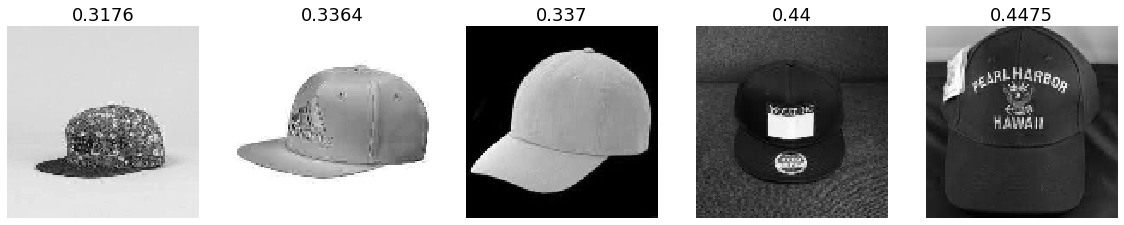

In [19]:
top_wrong_caps_ix = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values().index.values[:5]
top_wrong_caps_values = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values().values[:5]
plot_images(X_test[top_wrong_caps_ix],titles=top_wrong_caps_values)

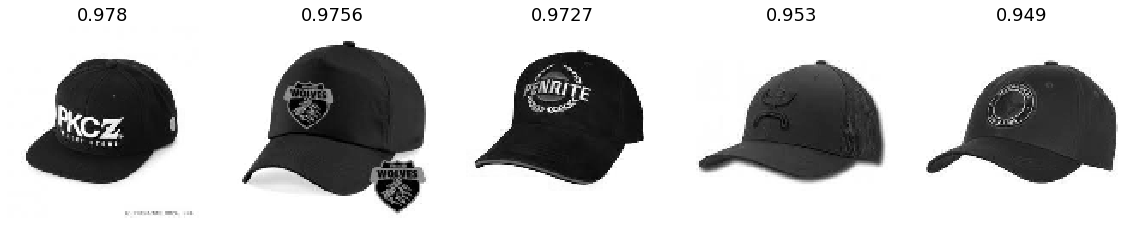

In [20]:
top_correct_caps_ix = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values(ascending=False).index.values[:5]
top_correct_caps_values = test_prediction_data[test_prediction_data['actual cap'] == 1]['predicted_cap'].sort_values(ascending=False).values[:5]
plot_images(X_test[top_correct_caps_ix],titles=top_correct_caps_values)

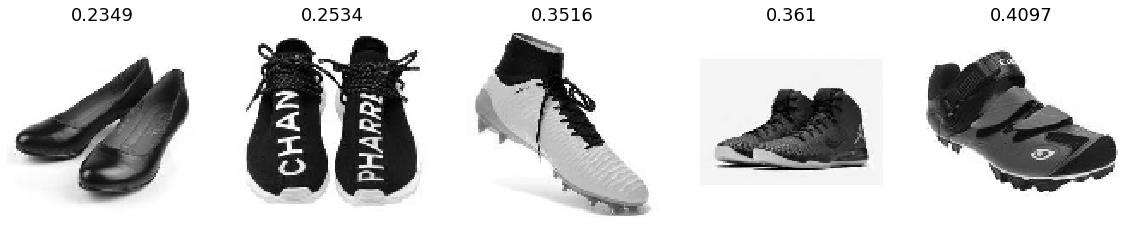

In [21]:
top_wrong_shoes_ix = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values().index.values[:5]
top_wrong_shoes_values = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values().values[:5]
plot_images(X_test[top_wrong_shoes_ix],titles=top_wrong_shoes_values)

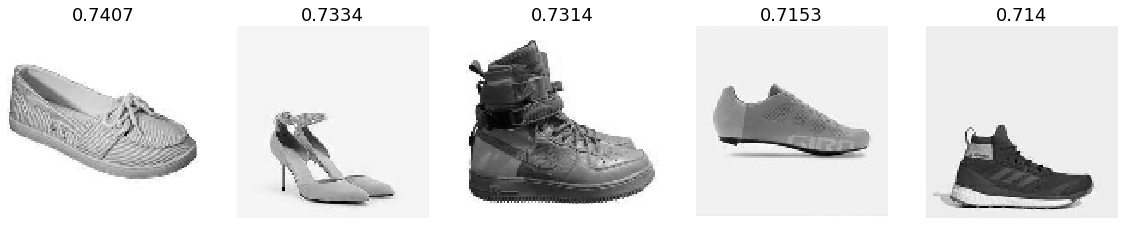

In [22]:
top_correct_shoes_ix = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values(ascending=False).index.values[:5]
top_correct_shoes_values = test_prediction_data[test_prediction_data['actual_shoes'] == 1]['predicted_shoes'].sort_values(ascending=False).values[:5]
plot_images(X_test[top_correct_shoes_ix],titles=top_correct_shoes_values)